This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [ ]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}/./data'.format(path_prefix),  train=True,download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /./data/FashionMNIST/raw



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

import sys
sys.path.insert(1, path_prefix)

Mounted at /content/gdrive


In [ ]:
feature_size = 28 * 28
# feature_shape = (mini_batch, (1, 28, 28)). # grayscale: 1, RGB: 3
feature_shape = (1, 28, 28)
label_counts = 10

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.

### **Part 1**

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.encoder_layers = nn.Sequential(
                    # nn.Flatten(),  # flatten to one-dimension
                    nn.Linear(in_features=feature_size, out_features=output_size)
                    )
                
            def forward(self, x):
                # needs your implementation
                # flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                f = nn.Flatten()
                fx = f(x)
                z = self.encoder_layers(fx)
                return z
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(
                        in_features=input_size, out_features=feature_size),
                    nn.Sigmoid()
                    )
               
            def forward(self, z):
                # needs your implementation
                # reconstructed_no_sigmoid = self.decoder_output_layer(z)
                # reconstructed_no_reshape = self.decoder_output_layer_sigmoid(reconstructed_no_sigmoid)
                reconstructedz = self.decoder_layers(z)
                r = nn.Unflatten(1, feature_shape)
                reconstructed = r(reconstructedz)
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         # return (x with Gaussian noise)
    #     elif noise_type=='Dropout':
    #         return (x with Dropout noise)

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

### **Part 2**

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.encoder_layers = nn.Sequential(  
                    nn.Linear(in_features=feature_size, out_features=1024),
                    nn.ReLU(),
                    nn.Linear(in_features=1024, out_features=output_size)
                )
                
            def forward(self, x):
                # needs your implementation
                # flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                f = nn.Flatten()  # flatten to one-dimension
                fx = f(x)
                z = self.encoder_layers(fx)
                return z
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(in_features=input_size, out_features=1024),
                    nn.ReLU(),
                    nn.Linear(in_features=1024, out_features=feature_size),
                    nn.Sigmoid()
                    )
               
            def forward(self, z):
                # needs your implementation
                reconstructedz = self.decoder_layers(z)
                r = nn.Unflatten(1, feature_shape)
                reconstructed = r(reconstructedz)
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         # return (x with Gaussian noise)
    #     elif noise_type=='Dropout':
    #         return (x with Dropout noise)

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

### **Part 3 (no noise)**

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):
        # self.noise_type = noise_type
        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.layers = nn.Sequential( 
                    nn.Linear(in_features=feature_size, out_features=output_size)
                    )
                
            def forward(self, x):
                # needs your implementation
                # flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                # f = nn.Flatten()  # flatten to one-dimension
                # fx = f(x)
                fx = x.reshape(-1, 784)
                z = self.layers(fx)
                return z
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(
                        in_features=input_size, out_features=feature_size),
                    nn.Tanh()
                    )
               
            def forward(self, z):
                # needs your implementation
                rec = self.decoder_layers(z)
                # reconstructed = torch.reshape(rec, (-1,1,28,28))
                reconstructed = rec.reshape(rec.size(0), 1, 28, 28)               
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         gnoise = torch.randn_like(x)
    #         gnoise_x = x + gnoise
    #         return gnoise_x
    #     elif noise_type=='Dropout':
    #         d = nn.Dropout(p=0.5)
    #         dnoise = d(x)
    #         return dnoise

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        # noised_x = self.add_noise(x, self.noise_type)
        # new_x = torch.from_numpy(noised_x)
        x0 = self.encoder(x)
        x = self.decoder(x0)
        # for the VAE forward function should also return mu and logvar
        return x

### **Part 3 (with noise)**

In [ ]:
class DAE(nn.Module):

    def __init__(self,dim_latent_representation=2, noise_type='Gaussian'):
        self.noise_type = noise_type
        super(DAE,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.layers = nn.Sequential( 
                    nn.Linear(in_features=feature_size, out_features=output_size)
                    )
                
            def forward(self, x):
                # needs your implementation
                # flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                # f = nn.Flatten()  # flatten to one-dimension
                # fx = f(x)
                fx = x.reshape(-1, 784)
                z = self.layers(fx)
                return z
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(
                        in_features=input_size, out_features=feature_size),
                    nn.Tanh()
                    )
               
            def forward(self, z):
                # needs your implementation
                rec = self.decoder_layers(z)
                # reconstructed = torch.reshape(rec, (-1,1,28,28))
                reconstructed = rec.reshape(rec.size(0), 1, 28, 28)               
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    def add_noise(self, x, noise_type):
        if noise_type=='Gaussian':
            gnoise = torch.randn_like(x)
            gnoise_x = x + gnoise
            return gnoise_x
        elif noise_type=='Dropout':
            d = nn.Dropout(p=0.5)
            dnoise = d(x)
            return dnoise

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        noised_x = self.add_noise(x, self.noise_type)
        # new_x = torch.from_numpy(noised_x)
        x0 = self.encoder(noised_x)
        x = self.decoder(x0)
        # for the VAE forward function should also return mu and logvar
        return x

### **Part 4 (just autoencoder)**

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):
        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.layers = nn.Sequential( 
                    nn.Linear(in_features=feature_size, out_features=output_size)
                    )
                
            def forward(self, x):
                # needs your implementation
                # flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                # f = nn.Flatten()  # flatten to one-dimension
                # fx = f(x)
                fx = x.reshape(-1, 784)
                z = self.layers(fx)
                return z
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(
                        in_features=input_size, out_features=feature_size),
                    nn.Tanh()
                    )
               
            def forward(self, z):
                # needs your implementation
                rec = self.decoder_layers(z)
                # reconstructed = torch.reshape(rec, (-1,1,28,28))
                reconstructed = rec.reshape(rec.size(0), 1, 28, 28)               
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         gnoise = torch.randn_like(x)
    #         gnoise_x = x + gnoise
    #         return gnoise_x
    #     elif noise_type=='Dropout':
    #         d = nn.Dropout(p=0.5)
    #         dnoise = d(x)
    #         return dnoise

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        # noised_x = self.add_noise(x, self.noise_type)
        # new_x = torch.from_numpy(noised_x)
        x0 = self.encoder(x)
        x = self.decoder(x0)
        # for the VAE forward function should also return mu and logvar
        return x

### **Part 4 (VAE)** 

In [ ]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation=2):
        # self.noise_type = noise_type
        super(VAE,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=dim_latent_representation):
                super(Encoder, self).__init__()
                # needs your implementation
                self.layers = nn.Sequential( 
                    nn.Linear(in_features=28*28, out_features=dim_latent_representation)
                    )
                self.fc1 = nn.Linear(dim_latent_representation, dim_latent_representation)
                self.fc2 = nn.Linear(dim_latent_representation, dim_latent_representation)
                
            def forward(self, x):
                # needs your implementation
                flattened_x = torch.flatten(x, start_dim=1)  # same as nn.Flatten() 
                # f = nn.Flatten()  # flatten to one-dimension
                # fx = f(x)
                # fx = x.reshape(-1, 784)
                x_hat = self.layers(flattened_x)
                mu = self.fc1(x_hat)
                logvar = self.fc2(x_hat)
                return mu, logvar
                

        class Decoder(nn.Module):
            def __init__(self, input_size=dim_latent_representation):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoder_layers = nn.Sequential(
                    nn.Linear(
                        in_features=dim_latent_representation, out_features=feature_size),
                    nn.Tanh()
                    )
               
            def forward(self, z):
                # needs your implementation
                rec = self.decoder_layers(z)
                reconstructed = rec.view(-1,1,28,28)
                # reconstructed = rec.reshape(rec.size(0), 1, 28, 28)               
                return reconstructed

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         gnoise = torch.randn_like(x)
    #         gnoise_x = x + gnoise
    #         return gnoise_x
    #     elif noise_type=='Dropout':
    #         d = nn.Dropout(p=0.5)
    #         dnoise = d(x)
    #         return dnoise

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            reparametrized_mu = mu + eps * std
            return reparametrized_mu
        else:
            return mu

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        # noised_x = self.add_noise(x, self.noise_type)
        # new_x = torch.from_numpy(noised_x)
        # x0 = self.encoder(noised_x)
        # x1 = self.decoder(x0)
        # for the VAE forward function should also return mu and logvar
        mu, logvar = self.encoder(x)
        # logvar = self.encoder(x)
        z = self.reparameterise(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

### Training code for Part 1,2

In [ ]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=2)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)


try:
    for epoch in range(1, EPOCH_NUMBER + 1):
      trainer.train(epoch)
      trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
      print("Manual Interruption")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:14<00:00, 129.24it/s]

====> Epoch: 1 Average loss: 0.9197



100%|██████████| 313/313 [00:02<00:00, 146.28it/s]


====> Val set loss (reconstruction error) : 0.8240


100%|██████████| 1875/1875 [00:14<00:00, 130.24it/s]

====> Epoch: 2 Average loss: 0.8048



100%|██████████| 313/313 [00:02<00:00, 141.34it/s]

====> Val set loss (reconstruction error) : 0.7876



100%|██████████| 1875/1875 [00:14<00:00, 130.38it/s]

====> Epoch: 3 Average loss: 0.7810



100%|██████████| 313/313 [00:02<00:00, 150.62it/s]

====> Val set loss (reconstruction error) : 0.7711



100%|██████████| 1875/1875 [00:14<00:00, 129.81it/s]

====> Epoch: 4 Average loss: 0.7679



100%|██████████| 313/313 [00:02<00:00, 145.08it/s]

====> Val set loss (reconstruction error) : 0.7596



100%|██████████| 1875/1875 [00:14<00:00, 129.64it/s]

====> Epoch: 5 Average loss: 0.7596



100%|██████████| 313/313 [00:02<00:00, 145.72it/s]

====> Val set loss (reconstruction error) : 0.7568



100%|██████████| 1875/1875 [00:14<00:00, 128.30it/s]

====> Epoch: 6 Average loss: 0.7586



100%|██████████| 313/313 [00:02<00:00, 147.47it/s]

====> Val set loss (reconstruction error) : 0.7545



100%|██████████| 1875/1875 [00:14<00:00, 129.63it/s]

====> Epoch: 7 Average loss: 0.7563



100%|██████████| 313/313 [00:02<00:00, 145.79it/s]

====> Val set loss (reconstruction error) : 0.7539



100%|██████████| 1875/1875 [00:14<00:00, 127.50it/s]

====> Epoch: 8 Average loss: 0.7547



100%|██████████| 313/313 [00:02<00:00, 145.24it/s]

====> Val set loss (reconstruction error) : 0.7518



100%|██████████| 1875/1875 [00:14<00:00, 130.36it/s]

====> Epoch: 9 Average loss: 0.7539



100%|██████████| 313/313 [00:02<00:00, 148.37it/s]

====> Val set loss (reconstruction error) : 0.7517



100%|██████████| 1875/1875 [00:14<00:00, 129.12it/s]

====> Epoch: 10 Average loss: 0.7536



100%|██████████| 313/313 [00:02<00:00, 146.21it/s]

====> Val set loss (reconstruction error) : 0.7514


### Training Code for Part 3

In [ ]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

## uncomment for autoencoder:
# autoer = Autoencoder(dim_latent_representation=30)
# trainer = Autoencoder_Trainer(autoencoder_model=autoer,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

## uncomment for DAE with 2 noises:
# dae = DAE(dim_latent_representation=30, noise_type='Gaussian')
dae = DAE(dim_latent_representation=30, noise_type='Dropout')
trainer = Autoencoder_Trainer(autoencoder_model=dae,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
      trainer.train(epoch)
      trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
      print("Manual Interruption")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:16<00:00, 113.61it/s]

====> Epoch: 1 Average loss: 0.5981



100%|██████████| 313/313 [00:02<00:00, 130.54it/s]

====> Val set loss (reconstruction error) : 0.5462



100%|██████████| 1875/1875 [00:16<00:00, 116.99it/s]

====> Epoch: 2 Average loss: 0.5394



100%|██████████| 313/313 [00:02<00:00, 135.93it/s]

====> Val set loss (reconstruction error) : 0.5323



100%|██████████| 1875/1875 [00:15<00:00, 117.52it/s]

====> Epoch: 3 Average loss: 0.5307



100%|██████████| 313/313 [00:02<00:00, 138.73it/s]

====> Val set loss (reconstruction error) : 0.5268



100%|██████████| 1875/1875 [00:15<00:00, 117.50it/s]

====> Epoch: 4 Average loss: 0.5271



100%|██████████| 313/313 [00:02<00:00, 135.17it/s]

====> Val set loss (reconstruction error) : 0.5254



100%|██████████| 1875/1875 [00:15<00:00, 118.02it/s]

====> Epoch: 5 Average loss: 0.5260



100%|██████████| 313/313 [00:02<00:00, 135.62it/s]

====> Val set loss (reconstruction error) : 0.5243



100%|██████████| 1875/1875 [00:15<00:00, 119.57it/s]

====> Epoch: 6 Average loss: 0.5257



100%|██████████| 313/313 [00:02<00:00, 138.35it/s]

====> Val set loss (reconstruction error) : 0.5249



100%|██████████| 1875/1875 [00:15<00:00, 118.58it/s]

====> Epoch: 7 Average loss: 0.5256



100%|██████████| 313/313 [00:02<00:00, 130.17it/s]

====> Val set loss (reconstruction error) : 0.5252



100%|██████████| 1875/1875 [00:15<00:00, 119.97it/s]

====> Epoch: 8 Average loss: 0.5255



100%|██████████| 313/313 [00:02<00:00, 139.91it/s]

====> Val set loss (reconstruction error) : 0.5247



100%|██████████| 1875/1875 [00:15<00:00, 118.04it/s]

====> Epoch: 9 Average loss: 0.5255



100%|██████████| 313/313 [00:02<00:00, 140.26it/s]

====> Val set loss (reconstruction error) : 0.5247



100%|██████████| 1875/1875 [00:15<00:00, 120.21it/s]

====> Epoch: 10 Average loss: 0.5254



100%|██████████| 313/313 [00:02<00:00, 137.15it/s]

====> Val set loss (reconstruction error) : 0.5245


### Training code for Part 4

In [ ]:
from VAE_starter import VAE_Trainer
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

# # for autoencoder
# ae = Autoencoder(dim_latent_representation=30)
# trainer = Autoencoder_Trainer(autoencoder_model=ae,learning_rate=LEARNING_RATE,path_prefix=path_prefix)
# # for VAE
vae = VAE(dim_latent_representation=30)
trainer = VAE_Trainer(autoencoder_model=vae,learning_rate=LEARNING_RATE,path_prefix=path_prefix)


try:
    for epoch in range(1, EPOCH_NUMBER + 1):
      trainer.train(epoch)
      trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
      print("Manual Interruption")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1875/1875 [00:14<00:00, 126.15it/s]

====> Epoch: 1 Average loss: 0.5809



100%|██████████| 313/313 [00:02<00:00, 147.72it/s]

====> Val set loss (reconstruction error) : 0.5258



100%|██████████| 1875/1875 [00:14<00:00, 125.57it/s]

====> Epoch: 2 Average loss: 0.5162



100%|██████████| 313/313 [00:02<00:00, 146.09it/s]

====> Val set loss (reconstruction error) : 0.5077



100%|██████████| 1875/1875 [00:14<00:00, 126.28it/s]

====> Epoch: 3 Average loss: 0.5062



100%|██████████| 313/313 [00:02<00:00, 146.02it/s]

====> Val set loss (reconstruction error) : 0.5032



100%|██████████| 1875/1875 [00:15<00:00, 124.92it/s]

====> Epoch: 4 Average loss: 0.5037



100%|██████████| 313/313 [00:02<00:00, 146.09it/s]


====> Val set loss (reconstruction error) : 0.5019


100%|██████████| 1875/1875 [00:14<00:00, 125.80it/s]

====> Epoch: 5 Average loss: 0.5029



100%|██████████| 313/313 [00:02<00:00, 146.90it/s]

====> Val set loss (reconstruction error) : 0.5015



100%|██████████| 1875/1875 [00:15<00:00, 124.49it/s]

====> Epoch: 6 Average loss: 0.5026



100%|██████████| 313/313 [00:02<00:00, 143.59it/s]

====> Val set loss (reconstruction error) : 0.5014



100%|██████████| 1875/1875 [00:14<00:00, 125.77it/s]

====> Epoch: 7 Average loss: 0.5024



100%|██████████| 313/313 [00:02<00:00, 146.99it/s]

====> Val set loss (reconstruction error) : 0.5012



100%|██████████| 1875/1875 [00:15<00:00, 122.89it/s]

====> Epoch: 8 Average loss: 0.5023



100%|██████████| 313/313 [00:02<00:00, 144.24it/s]

====> Val set loss (reconstruction error) : 0.5011



100%|██████████| 1875/1875 [00:15<00:00, 124.18it/s]

====> Epoch: 9 Average loss: 0.5022



100%|██████████| 313/313 [00:02<00:00, 146.76it/s]

====> Val set loss (reconstruction error) : 0.5011



100%|██████████| 1875/1875 [00:15<00:00, 123.38it/s]

====> Epoch: 10 Average loss: 0.5021



100%|██████████| 313/313 [00:02<00:00, 145.67it/s]

====> Val set loss (reconstruction error) : 0.5010


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

### for Part 1,2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


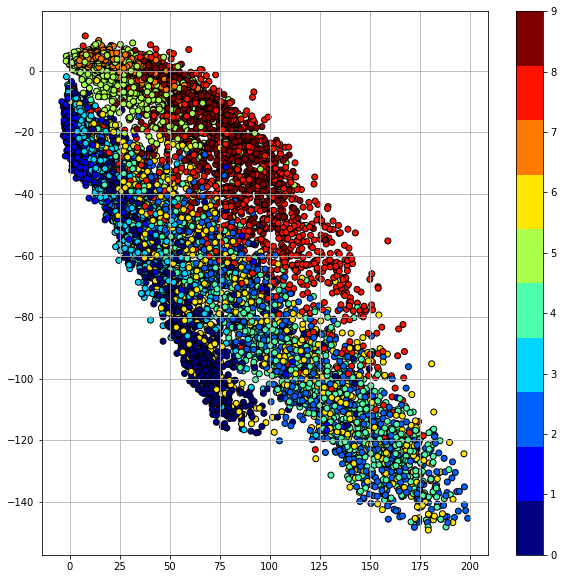

In [ ]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
scatter_plot(latent_representations=z,labels=label)

### for Part 4 (TSNE - autoencoder)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


this is z shape:
(10000, 30)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


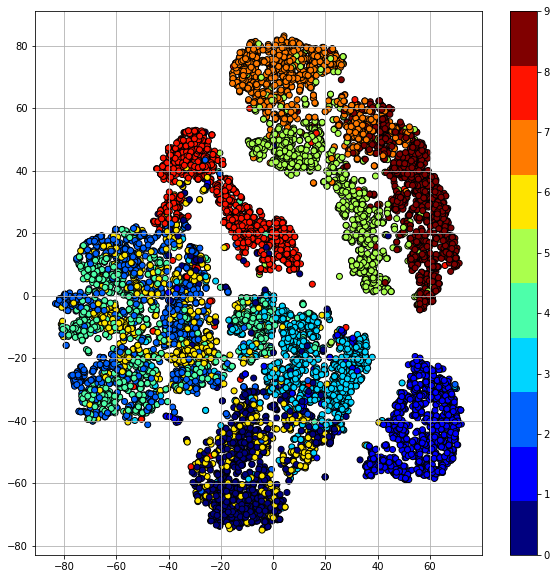

In [ ]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    print('this is z shape:')
    print(z.shape)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(z)
scatter_plot(latent_representations=tsne_results,labels=label)

### for Part 4 (TSNE - VAE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


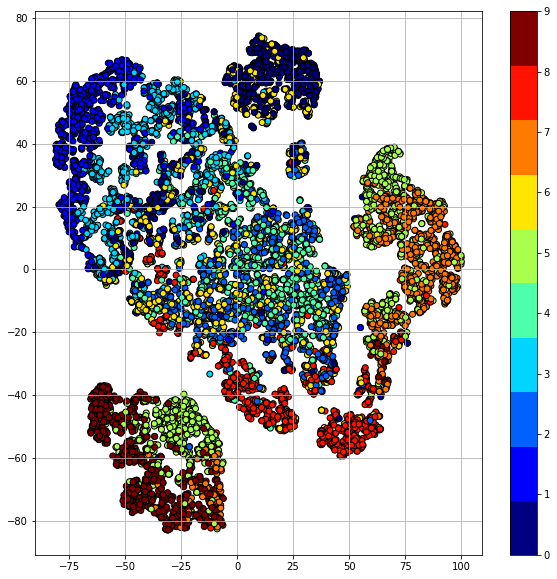

In [ ]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        
        
        mu, logvar = model.encoder(x.to(trainer.device))
        z_ = model.reparameterise(mu,logvar)
        z += z_.cpu().tolist()
        # z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from VAE_starter import scatter_plot
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(z)
scatter_plot(latent_representations=tsne_results,labels=label)

### for Part 3 (kernel)

Parameter containing:
tensor([[ 0.0129, -0.0110, -0.0227,  ...,  0.0709,  0.0334,  0.0166],
        [-0.0007,  0.0241, -0.0076,  ...,  0.0346,  0.0222, -0.0168],
        [ 0.0160,  0.0351,  0.0237,  ...,  0.0067,  0.0188,  0.0304],
        ...,
        [-0.0032, -0.0127, -0.0050,  ...,  0.0492,  0.0127, -0.0005],
        [ 0.0064,  0.0049, -0.0004,  ..., -0.0006, -0.0200,  0.0120],
        [ 0.0110, -0.0083,  0.0186,  ..., -0.1165, -0.0216, -0.0255]],
       requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
torch.Size([30, 784])


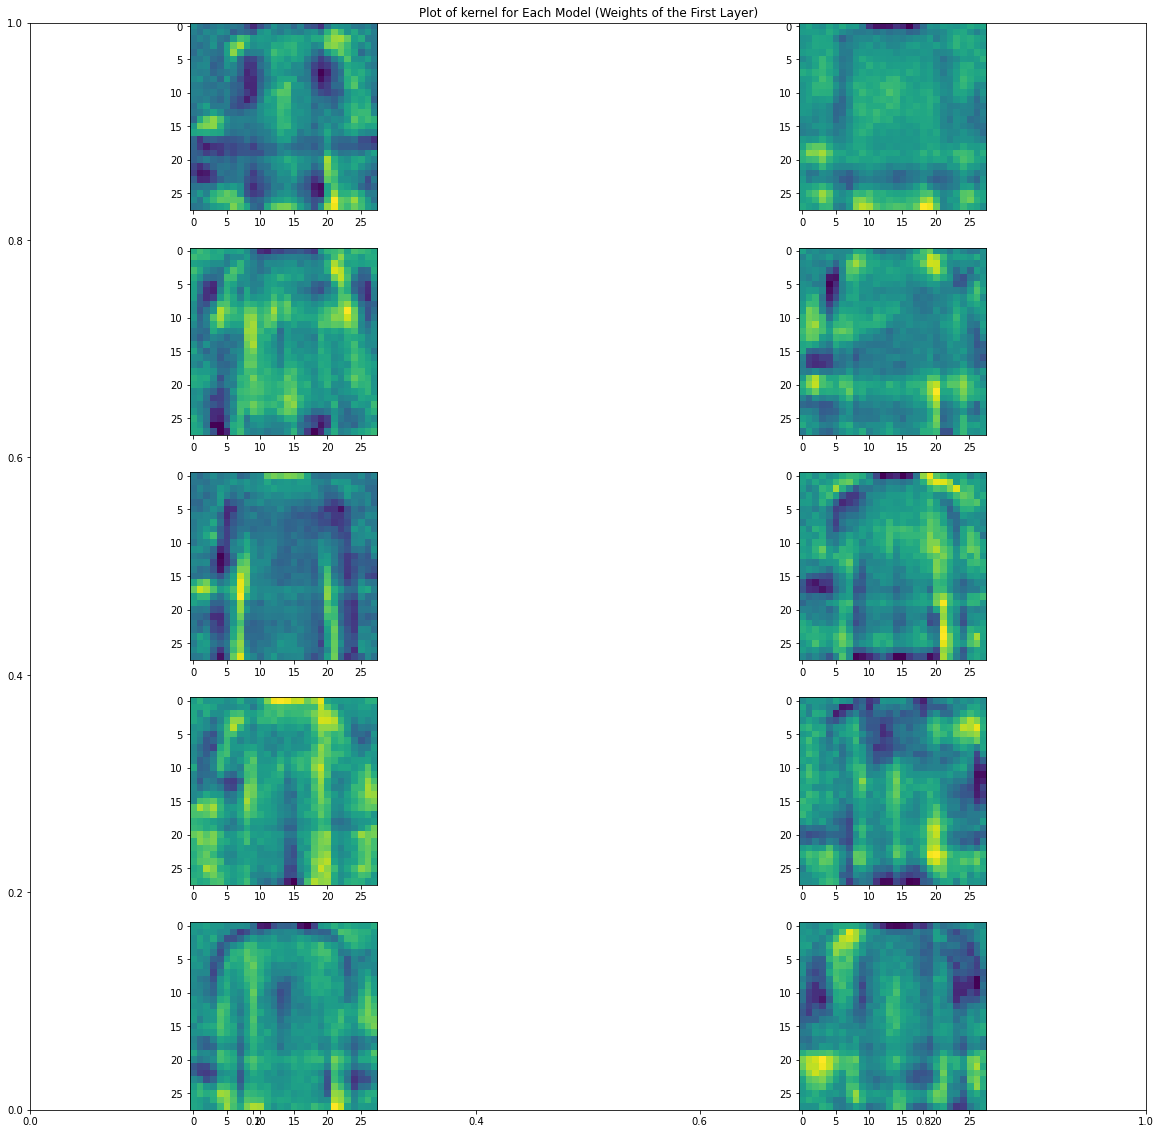

In [ ]:
from autoencoder_starter import Plot_Kernel

## uncomment for autoencoder
# Plot_Kernel(autoer)
## uncomment for DAE with 2 noises
Plot_Kernel(dae)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


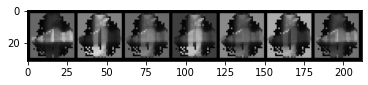

In [ ]:
with torch.no_grad():
    samples = torch.randn(7, 2).to(trainer.device)  # dimension is 2 now (should change accordingly)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Original images


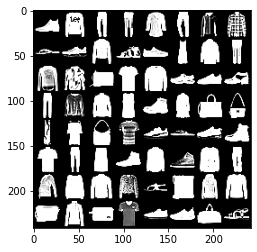

In [ ]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
# from VAE_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

### for Part 1,2,3

Reconstructed images


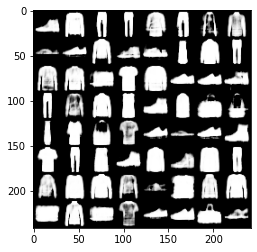

In [ ]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

### for Part 4 (VAE)

In [ ]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images)[0].cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)